In [1]:
## Import Essential Data handling libraries
import pandas as pd
import numpy as np

from math import floor
from time import perf_counter

import matplotlib.pyplot as plt,seaborn as sns
import matplotlib as mpl
%matplotlib inline


from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

C:\Users\shivam.yadav\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Importing Machine Learning Libraries and functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.metrics import make_scorer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBClassifier

import lightgbm as lgb

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import RFECV

#### Loading Data

In [3]:
df_raw = pd.read_csv("..\data\creditcard.csv")

In [4]:
df_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


In [5]:
df_raw.drop(["Time"], axis = 1, inplace  = True)

In [6]:
# df = df_raw.copy()

##### Checking Class Distribution

In [7]:
print(df_raw.Class.value_counts())

print("\n","% distribution\n",df_raw.Class.value_counts(True)*100)

0    284315
1       492
Name: Class, dtype: int64

 % distribution
 0   99.827
1    0.173
Name: Class, dtype: float64


In [8]:
df_raw.shape

(284807, 30)

#### Scoring function

In [9]:
def AUPRC(y_true, y_pred_proba) :
    precision, recall, thresholds = precision_recall_curve(y_true = y_true, probas_pred= y_pred_proba)
    auprc = auc(recall, precision)
    return(np.round(auprc, 4))

#### Data Transformation
* 1. Quantile Transformation (normal distribution)
* 2. standard scaling the data

In [10]:
quantile_transformer = QuantileTransformer(output_distribution="normal")
standard_scaler = StandardScaler()

In [11]:
df_transformed = df_raw.copy()

for i in range(df_transformed.iloc[:,:-1].shape[1]):
    qt_transformed_var = quantile_transformer.fit_transform(df_transformed.iloc[:,i].values.reshape(-1,1))[:,0]
    qt_transformed_std_scaled = standard_scaler.fit_transform(qt_transformed_var.reshape(-1,1))[:,0]
    
    df_transformed.iloc[:,i] = qt_transformed_std_scaled

In [12]:
df_transformed.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994,-0.159,2.121,1.193,-0.304,0.720,0.289,0.202,0.441,0.305,-0.465,-0.887,-1.002,-0.521,1.782,-0.681,0.399,0.041,0.600,0.971,0.035,0.355,-0.455,0.080,0.194,-0.309,0.840,-0.325,1.028,0
1,0.461,0.220,-0.013,0.416,0.121,0.216,-0.160,0.168,-0.250,-0.117,1.641,1.360,0.509,-0.288,0.665,0.584,-0.075,-0.254,-0.227,-0.028,-0.669,-0.834,0.495,-0.649,0.272,0.385,-0.096,0.055,-0.839,0
2,-0.993,-1.269,1.387,0.345,-0.483,1.375,0.963,0.536,-1.455,0.452,0.567,-0.097,0.729,-0.320,2.810,-2.669,1.495,-0.167,-2.498,1.376,0.888,1.033,2.013,-1.122,-0.702,-0.192,-0.531,-0.767,1.588,0
3,-0.713,-0.286,1.406,-0.685,0.048,1.181,0.286,0.757,-1.356,0.059,-0.175,0.053,0.528,-0.489,-0.727,-1.282,-1.050,2.204,-1.520,-0.657,-0.262,-0.001,-0.791,-1.674,1.398,-0.390,0.524,0.575,0.921,0
4,-0.859,0.753,1.162,0.367,-0.378,0.399,0.705,-0.854,0.867,0.956,-0.740,0.555,1.389,-1.388,0.141,-0.659,-0.257,-0.047,1.106,1.237,0.064,1.076,-0.572,0.225,-0.413,1.024,1.071,1.457,0.596,0


##### Evaluating Tree Based Classifiers using selected features
1. 5 fold CV to estimate F1 and AUPRC : Actual Data
2. 5 fold CV to estimate F1 and AUPRC : SMOTE Oversampled Data    

In [18]:
#selected vars
all_vars = list(set(list(df_transformed.columns)) - set(["V8","V13","V15", "V19", "V20", "V22", "V23","V24", "V25", "V26", "Amount"]))
 
new_df = df_transformed[all_vars]

In [19]:
new_df.head()

,V11,V10,V2,V17,V7,V6,V27,V5,V14,V3,V16,V28,V21,V18,V12,V4,V9,Class,V1
0,-0.465,0.305,-0.159,0.399,0.289,0.720,0.840,-0.304,-0.521,2.121,-0.681,-0.325,0.035,0.041,-0.887,1.193,0.441,0,-0.994
1,1.641,-0.117,0.220,-0.075,-0.160,0.216,-0.096,0.121,-0.288,-0.013,0.584,0.055,-0.669,-0.254,1.360,0.416,-0.250,0,0.461
2,0.567,0.452,-1.269,1.495,0.963,1.375,-0.531,-0.483,-0.320,1.387,-2.669,-0.767,0.888,-0.167,-0.097,0.345,-1.455,0,-0.993
3,-0.175,0.059,-0.286,-1.050,0.286,1.181,0.524,0.048,-0.489,1.406,-1.282,0.575,-0.262,2.204,0.053,-0.685,-1.356,0,-0.713
4,-0.740,0.956,0.753,-0.257,0.705,0.399,1.071,-0.378,-1.388,1.162,-0.659,1.457,0.064,-0.047,0.555,0.367,0.867,0,-0.859


In [20]:
def create_stratified_folds(data, k_fold_num, target_variable):
    data["kfold"] = -1 # we create a new column called kfold and fill it with -1
    data = data.sample(frac=1).reset_index(drop=True) # the next step is to randomize the rows of the data

    y = data[target_variable].values

    kf = model_selection.StratifiedKFold(n_splits= k_fold_num)

    for fold, (trn_, partitioned_idx_) in enumerate(kf.split(X=data, y = y)):
        data.loc[partitioned_idx_, 'kfold'] = fold
    return(data)

In [21]:
#### Scoring function
def AUPRC(y_true, y_pred_proba) :
    precision, recall, thresholds = precision_recall_curve(y_true = y_true, probas_pred= y_pred_proba)
    auprc = auc(recall, precision)
    return(np.round(auprc, 4))

In [22]:
# defining models
models = []
models.append(('RF', RandomForestClassifier(n_jobs = -1)))
models.append(('ETC', ExtraTreesClassifier( n_jobs = -1)))
models.append(('XGB', XGBClassifier(n_jobs = -1)))

In [23]:
# Creating stratified k-fold within the data
df = new_df.copy()
k_fold_num = 5
df = create_stratified_folds(df, k_fold_num = 5, target_variable = "Class")
features = [f for f in df.columns if f not in ["kfold","Class"]]

#### 1. Algorithms Evaluation : 5 fold CV to estimate F1 and AUPRC : Actual Data

In [24]:
F1_score_results = {}
AUPRC_results = {}
time_taken = {}

for name, model in models:
    t0 = perf_counter()
    
    cv_auprc = []
    f1_scores = []
    for fold in range(k_fold_num):
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        x_train = df_train[features].values
        x_valid = df_valid[features].values
        
        model.fit(x_train, df_train.Class.values)
        
        valid_preds = model.predict_proba(x_valid)[:, 1]
        valid_preds_binary = model.predict(x_valid)
        
        auprc = AUPRC(df_valid.Class.values, valid_preds)
        f1 = f1_score(df_valid.Class.values, valid_preds_binary)
        
        cv_auprc.append(auprc)
        f1_scores.append(np.round(f1,4))
        
    t1 = perf_counter()
    
    AUPRC_results[name] = cv_auprc
    F1_score_results[name] = f1_scores
    time_taken[name] = np.round((t1 - t0)/60,2)
    
    print("Model : ", name)
    print("Average Area Under Precision Recall Curve = ", np.round(np.mean(cv_auprc),2))
    print("Average F1 score = ", np.round(np.mean(f1_scores),2))
    print("Time Taken in minutes = ", time_taken[name])
    print("\n")

Model :  RF
Average Area Under Precision Recall Curve =  0.84
Average F1 score =  0.86
Time Taken in minutes =  3.47


Model :  ETC
Average Area Under Precision Recall Curve =  0.85
Average F1 score =  0.86
Time Taken in minutes =  0.77


Model :  XGB
Average Area Under Precision Recall Curve =  0.85
Average F1 score =  0.86
Time Taken in minutes =  2.42




In [25]:
AUPRC_results

{'RF': [0.8203, 0.8729, 0.8187, 0.8362, 0.8711],
 'ETC': [0.8368, 0.8728, 0.823, 0.8614, 0.8579],
 'XGB': [0.8392, 0.8726, 0.821, 0.8562, 0.8579]}

In [26]:
F1_score_results

{'RF': [0.8432, 0.8539, 0.875, 0.8804, 0.8539],
 'ETC': [0.8387, 0.8715, 0.8571, 0.8696, 0.8571],
 'XGB': [0.8342, 0.8729, 0.8778, 0.8817, 0.8457]}

Text(0.5, 0, 'Model')

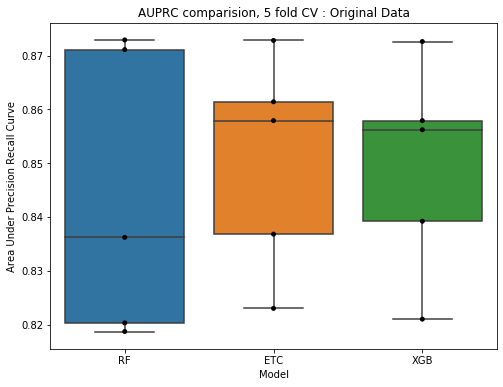

In [27]:
## Plotting 
AUPRC_results = pd.DataFrame(AUPRC_results)
plt.figure(figsize=(8, 6))
sns.boxplot(data=AUPRC_results)
sns.swarmplot(data=AUPRC_results, color = "black")
plt.title("AUPRC comparision, 5 fold CV : Original Data")
plt.ylabel("Area Under Precision Recall Curve")
plt.xlabel("Model")

#### 2. Algorithm Evaluation on Oversampled data : SMOTE
For each Fold :
    * splitting the fold data into train and validation
    * Oversampling the train data
    * Fitting model on oversampled data
    * Prediction on the left out validation set

In [28]:
F1_score_results = {}
AUPRC_results = {}
time_taken = {}

for name, model in models:
    t0 = perf_counter()
    
    cv_auprc = []
    f1_scores = []
    for fold in range(k_fold_num):
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)
        
        ## Oversampling the df_train data : SMOTE
        x_train = df_train[features].values
        y_train = df_train["Class"].values
        
        x_train_smote, y_train_smote = SMOTE().fit_sample(x_train, y_train)
        
        ## Validation dataset
        x_valid = df_valid[features].values
        y_valid = df_valid["Class"].values
        
        model.fit(x_train_smote, y_train_smote)
        
        valid_preds = model.predict_proba(x_valid)[:, 1]
        valid_preds_binary = model.predict(x_valid)
        
        auprc = AUPRC(y_valid, valid_preds)
        f1 = f1_score(y_valid, valid_preds_binary)
        
        cv_auprc.append(auprc)
        f1_scores.append(np.round(f1,4))
        
    t1 = perf_counter()
    
    AUPRC_results[name] = cv_auprc
    F1_score_results[name] = f1_scores
    time_taken[name] = np.round((t1 - t0)/60,2)
    
    print("Model : ", name)
    print("Average Area Under Precision Recall Curve = ", np.round(np.mean(cv_auprc),2))
    print("Average F1 score = ", np.round(np.mean(f1_scores),2))
    print("Time Taken in minutes = ", time_taken[name])
    print("\n")

Model :  RF
Average Area Under Precision Recall Curve =  0.84
Average F1 score =  0.84
Time Taken in minutes =  6.45


Model :  ETC
Average Area Under Precision Recall Curve =  0.85
Average F1 score =  0.85
Time Taken in minutes =  2.73


Model :  XGB
Average Area Under Precision Recall Curve =  0.83
Average F1 score =  0.76
Time Taken in minutes =  7.31




In [29]:
AUPRC_results

{'RF': [0.8083, 0.8738, 0.822, 0.8297, 0.8429],
 'ETC': [0.8109, 0.8861, 0.8264, 0.858, 0.8512],
 'XGB': [0.8211, 0.8491, 0.8132, 0.8456, 0.8428]}

In [30]:
F1_score_results

{'RF': [0.8122, 0.8723, 0.8041, 0.8485, 0.8556],
 'ETC': [0.8308, 0.8526, 0.837, 0.8601, 0.8649],
 'XGB': [0.7615, 0.7757, 0.7281, 0.7467, 0.765]}

Text(0.5, 0, 'Model')

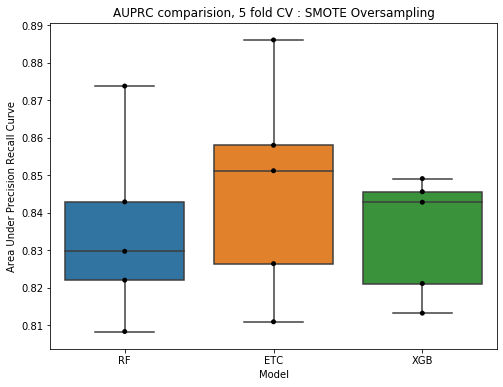

In [31]:
## Plotting 
AUPRC_results = pd.DataFrame(AUPRC_results)
plt.figure(figsize=(8, 6))
sns.boxplot(data=AUPRC_results)
sns.swarmplot(data=AUPRC_results, color = "black")
plt.title("AUPRC comparision, 5 fold CV : SMOTE Oversampling")
plt.ylabel("Area Under Precision Recall Curve")
plt.xlabel("Model")